In [1]:
! pip install transformers
! pip install datasets 
! pip install --upgrade tqdm
! pip install torcheval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 3.7 MB/s eta 0:00:00
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.66.1
    Uninstalling tqdm-4.66.1:
      Successfully uninstalled tqdm-4.66.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
keras-cv 0.8.2 requires keras-core, which is not installed.
keras-nlp 0.9.3 requires keras-core, which is not installed.
beatrix-jupyterlab 2023.128.151533 requires jupyterlab~=3.6.0, but you have jupyterlab 4.1.6 which is incompatible.
momepy 0.7.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
spopt 0.6.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
ydata-profiling 4.6.4 requires numpy<1.26,>=1.16.0, but you have numpy 1.26.4 which is incompatible.

In [3]:
%load_ext autoreload
%autoreload 2

# torch
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torcheval.metrics.functional import binary_auroc
from torch.optim.lr_scheduler import ReduceLROnPlateau

# model
from transformers import AutoConfig, AutoModel, AutoTokenizer

# general
import os
from PIL import Image
import requests
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import cv2

In [4]:
print(torch.__version__)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device=='cuda')

2.1.2
True


In [5]:
path = "/kaggle/input/facebook-hateful-memes/hateful_memes/"

In [6]:
val_seen = pd.read_json(path+'dev_seen.jsonl',lines=True)
val_unseen= pd.read_json(path+'dev_unseen.jsonl',lines=True)
test_seen=pd.read_json(path+'test_seen.jsonl',lines=True)
test_unseen=pd.read_json(path+'test_unseen.jsonl',lines=True)
train = pd.read_json(path+'train.jsonl',lines=True)

In [7]:
train.label.value_counts()

label
0    5481
1    3019
Name: count, dtype: int64

In [8]:
val_seen.label.value_counts()

label
0    253
1    247
Name: count, dtype: int64

In [9]:
class HatefulMemesDataset(Dataset):
    def __init__(self, jsonl_file, root_dir, transform=None):
        self.annotations = pd.read_json(jsonl_file, lines=True)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        id = self.annotations.loc[idx, 'id']
        img_path = os.path.join(self.root_dir, self.annotations.loc[idx, 'img'])
        label = self.annotations.loc[idx, 'label']
        text = self.annotations.loc[idx, 'text']

        try:
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            if self.transform:
                image = self.transform(image)

            sample = {"id": id, "image": image, "label": label, "text": text}

            return sample

        except Exception as e:
            print(f"Error loading image at index {idx}: {e}")
            return None

In [10]:
hm_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

In [11]:
train_jsonl = os.path.join(path, "train.jsonl")
val_seen_jsonl = os.path.join(path, "dev_seen.jsonl")
val_unseen_jsonl = os.path.join(path, "dev_unseen.jsonl")
test_seen_jsonl = os.path.join(path, "test_seen.jsonl")
test_unseen_jsonl = os.path.join(path, "test_unseen.jsonl")

In [12]:
train_dataset = HatefulMemesDataset(jsonl_file=train_jsonl, root_dir=path, transform=hm_transform)
val_seen_dataset = HatefulMemesDataset(jsonl_file=val_seen_jsonl, root_dir=path, transform=hm_transform)
val_unseen_dataset = HatefulMemesDataset(jsonl_file=val_unseen_jsonl, root_dir=path, transform=hm_transform)
test_seen_dataset = HatefulMemesDataset(jsonl_file=test_seen_jsonl, root_dir=path, transform=hm_transform)
test_unseen_dataset = HatefulMemesDataset(jsonl_file=test_unseen_jsonl, root_dir=path, transform=hm_transform)

In [13]:
batch_size = 64

In [14]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_seen_dataloader = DataLoader(val_seen_dataset, batch_size=batch_size, shuffle=False)
# val_unseen_dataloader = DataLoader(val_unseen_dataset, batch_size=batch_size, shuffle=False)
# test_seen_dataloader = DataLoader(test_seen_dataset, batch_size=batch_size, shuffle=False)
# test_unseen_dataloader = DataLoader(test_unseen_dataset, batch_size=batch_size, shuffle=False)

In [15]:
# Combine datasets
val_dataset = ConcatDataset([val_seen_dataset, val_unseen_dataset])
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [16]:
# Combine datasets
test_dataset = ConcatDataset([test_seen_dataset, test_unseen_dataset])
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Resnet152

In [17]:
resnet152_model = models.resnet152(weights="ResNet152_Weights.DEFAULT", progress=True)
modules = list(resnet152_model.children())
r152_feature_extractor = nn.Sequential(*modules[:-1])
r152_feature_extractor.to(device)
for p in r152_feature_extractor.parameters():
    p.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth
100%|██████████| 230M/230M [00:01<00:00, 145MB/s]  


# BERT

In [30]:
model_name = 'Hate-speech-CNERG/bert-base-uncased-hatexplain'
tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=True)
bert_config = AutoConfig.from_pretrained(model_name) 
bert_model = AutoModel.from_pretrained(model_name, config=bert_config).to(device)

# Head

In [31]:
class TrainingHead(nn.Module):
    def __init__(self):
        super().__init__()

        self.linear_stack = nn.Sequential(
            nn.BatchNorm1d(2816),
            nn.Linear(2816, 1024),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(1024, 2),
        )
    
    def forward(self, x):
        logits = self.linear_stack(x)
        return logits

In [ ]:
head = TrainingHead()
head.to(device)

In [33]:
def metrics(losses, predictions, labels):
  average_loss = losses.mean().item()
  accuracy = (predictions == labels).sum().item() / labels.numel()
  auroc = binary_auroc(predictions, labels)
  return average_loss, accuracy, auroc

# Train

In [34]:
lr = 1e-4
epochs = 20
weight_decay = 0.0005

In [35]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(head.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=4, verbose=True)
early_stopping_counter = 0
early_stopping_patience = 6
best_validation_auroc = float('-inf')

In [36]:
model_path ="/kaggle/working/models/"

In [37]:
!mkdir -p models

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [38]:
# Train model head
for e in range(epochs):
    # Training
    train_losses = torch.zeros(len(train_dataloader)).to(device)
    train_predictions = torch.Tensor().to(device)
    train_labels = torch.Tensor().to(device)

    r152_feature_extractor.train()
    bert_model.train()
    head.train()

    for i, data in tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc="Epoch " + str(e+1) + " Training"):
        text = data['text']
        image = data['image'].to(device).float()
        labels = data['label'].to(device).to(torch.int64)

        optimizer.zero_grad()

        image_features = r152_feature_extractor(image).squeeze()

        tokenized_input = tokenizer(text, padding=True, return_tensors="pt").to(device)
        text_features = bert_model(**tokenized_input)

        concat_features = torch.cat((image_features, text_features["pooler_output"]), dim=1)

        scores = torch.squeeze(head(concat_features))
        predictions = scores.argmax(dim=-1)

        loss = criterion(scores, labels)
        loss.backward()
        optimizer.step()

        train_losses[i] = loss
        train_predictions = torch.cat((train_predictions, predictions))
        train_labels = torch.cat((train_labels, labels))

        train_average_loss, train_accuracy, train_auroc = metrics(train_losses, train_predictions, train_labels)

    # Validation
    validate_losses = torch.zeros(len(val_dataloader)).to(device)
    validate_predictions = torch.Tensor().to(device)
    validate_labels = torch.Tensor().to(device)

    r152_feature_extractor.eval()
    bert_model.eval()
    head.eval()

    with torch.no_grad():
        for i, data in tqdm(enumerate(val_dataloader), total=len(val_dataloader), desc="Epoch " + str(e+1) + " Validation"):
            text = data['text']
            image = data['image'].to(device).float()
            labels = data['label'].to(device).to(torch.int64)

            image_features = r152_feature_extractor(image).squeeze()

            tokenized_input = tokenizer(text, padding=True, return_tensors="pt").to(device)
            text_features = bert_model(**tokenized_input)

            concat_features = torch.cat((image_features, text_features["pooler_output"]), dim=1)

            scores = torch.squeeze(head(concat_features))
            predictions = scores.argmax(dim=-1)

            loss = criterion(scores, labels)

            validate_losses[i] = loss
            validate_predictions = torch.cat((validate_predictions, predictions), dim=0)
            validate_labels = torch.cat((validate_labels, labels), dim=0)

    validate_average_loss, validate_accuracy, validate_auroc = metrics(validate_losses, validate_predictions, validate_labels)

    # Update learning rate scheduler
    scheduler.step(validate_auroc)

    # Early stopping
    if validate_auroc > best_validation_auroc:
        best_validation_auroc = validate_auroc
        early_stopping_counter = 0
        # Save the best model
        torch.save(head, model_path + "/concat_bert_best.pt")
        print("New best model saved at epoch", e+1)
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_patience:
            print("Early stopping triggered at epoch", e+1)
            break

    # Additional logging or tasks can be performed here
    print("Epoch %d" % (e+1))
    print("Training Loss: %.4f. Validation Loss: %.4f. " % (train_average_loss, validate_average_loss))
    print("Training Accuracy: %.4f. Validation Accuracy: %.4f. " % (train_accuracy, validate_accuracy))
    print("Training AUROC: %.4f. Validation AUROC: %.4f. " % (train_auroc, validate_auroc))
    print("-----------------------------------")

print("Training complete.")

Epoch 1 Validation: 100%|██████████| 17/17 [00:32<00:00,  1.92s/it]


New best model saved at epoch 1
Epoch 1
Training Loss: 0.5667. Validation Loss: 0.7305. 
Training Accuracy: 0.7153. Validation Accuracy: 0.6087. 
Training AUROC: 0.6562. Validation AUROC: 0.5596. 
-----------------------------------


Epoch 2 Validation: 100%|██████████| 17/17 [00:22<00:00,  1.33s/it]


Epoch 2
Training Loss: 0.4927. Validation Loss: 0.7498. 
Training Accuracy: 0.7665. Validation Accuracy: 0.5952. 
Training AUROC: 0.7157. Validation AUROC: 0.5503. 
-----------------------------------


Epoch 3 Validation: 100%|██████████| 17/17 [00:22<00:00,  1.32s/it]


Epoch 3
Training Loss: 0.4460. Validation Loss: 0.7857. 
Training Accuracy: 0.7966. Validation Accuracy: 0.5981. 
Training AUROC: 0.7536. Validation AUROC: 0.5476. 
-----------------------------------


Epoch 4 Validation: 100%|██████████| 17/17 [00:21<00:00,  1.29s/it]


Epoch 4
Training Loss: 0.4163. Validation Loss: 0.8336. 
Training Accuracy: 0.8122. Validation Accuracy: 0.6010. 
Training AUROC: 0.7738. Validation AUROC: 0.5584. 
-----------------------------------


Epoch 5 Validation: 100%|██████████| 17/17 [00:22<00:00,  1.30s/it]


Epoch 5
Training Loss: 0.3749. Validation Loss: 0.8654. 
Training Accuracy: 0.8339. Validation Accuracy: 0.5942. 
Training AUROC: 0.8006. Validation AUROC: 0.5522. 
-----------------------------------


Epoch 6 Validation: 100%|██████████| 17/17 [00:22<00:00,  1.30s/it]


Epoch 00006: reducing learning rate of group 0 to 5.0000e-05.
Epoch 6
Training Loss: 0.3446. Validation Loss: 0.8415. 
Training Accuracy: 0.8526. Validation Accuracy: 0.5971. 
Training AUROC: 0.8259. Validation AUROC: 0.5583. 
-----------------------------------


Epoch 7 Validation: 100%|██████████| 17/17 [00:21<00:00,  1.29s/it]


New best model saved at epoch 7
Epoch 7
Training Loss: 0.2970. Validation Loss: 0.8712. 
Training Accuracy: 0.8856. Validation Accuracy: 0.6029. 
Training AUROC: 0.8619. Validation AUROC: 0.5606. 
-----------------------------------


Epoch 8 Validation: 100%|██████████| 17/17 [00:23<00:00,  1.39s/it]


New best model saved at epoch 8
Epoch 8
Training Loss: 0.2772. Validation Loss: 0.8702. 
Training Accuracy: 0.8991. Validation Accuracy: 0.6115. 
Training AUROC: 0.8776. Validation AUROC: 0.5732. 
-----------------------------------


Epoch 9 Validation: 100%|██████████| 17/17 [00:22<00:00,  1.34s/it]


Epoch 9
Training Loss: 0.2636. Validation Loss: 0.9161. 
Training Accuracy: 0.9053. Validation Accuracy: 0.5904. 
Training AUROC: 0.8877. Validation AUROC: 0.5461. 
-----------------------------------


Epoch 10 Validation: 100%|██████████| 17/17 [00:22<00:00,  1.31s/it]


Epoch 10
Training Loss: 0.2419. Validation Loss: 0.9240. 
Training Accuracy: 0.9140. Validation Accuracy: 0.6000. 
Training AUROC: 0.8974. Validation AUROC: 0.5573. 
-----------------------------------


Epoch 11 Validation: 100%|██████████| 17/17 [00:22<00:00,  1.30s/it]


Epoch 11
Training Loss: 0.2266. Validation Loss: 0.9161. 
Training Accuracy: 0.9256. Validation Accuracy: 0.5952. 
Training AUROC: 0.9110. Validation AUROC: 0.5508. 
-----------------------------------


Epoch 12 Validation: 100%|██████████| 17/17 [00:22<00:00,  1.30s/it]


Epoch 12
Training Loss: 0.2126. Validation Loss: 0.9194. 
Training Accuracy: 0.9305. Validation Accuracy: 0.5962. 
Training AUROC: 0.9172. Validation AUROC: 0.5558. 
-----------------------------------


Epoch 13 Validation: 100%|██████████| 17/17 [00:22<00:00,  1.33s/it]


Epoch 00013: reducing learning rate of group 0 to 2.5000e-05.
Epoch 13
Training Loss: 0.1991. Validation Loss: 0.9137. 
Training Accuracy: 0.9358. Validation Accuracy: 0.6048. 
Training AUROC: 0.9230. Validation AUROC: 0.5670. 
-----------------------------------


Epoch 14 Validation: 100%|██████████| 17/17 [00:22<00:00,  1.31s/it]

Early stopping triggered at epoch 14
Training complete.


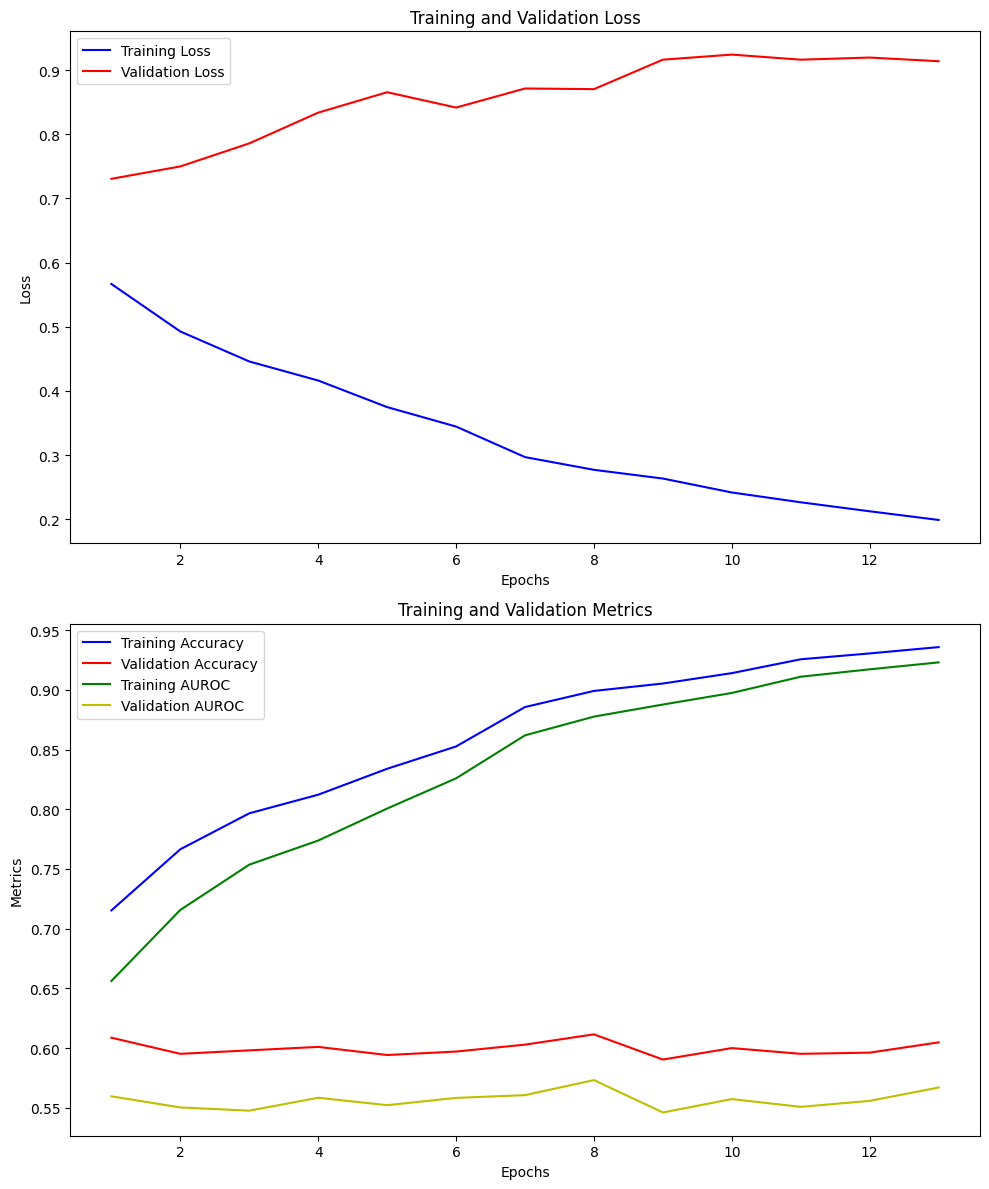

In [43]:
epochs = range(1, 14)

# Training and validation metrics
training_loss = [0.5667, 0.4927, 0.4460, 0.4163, 0.3749, 0.3446, 0.2970, 0.2772, 0.2636, 0.2419, 0.2266, 0.2126, 0.1991]
validation_loss = [0.7305, 0.7498, 0.7857, 0.8336, 0.8654, 0.8415, 0.8712, 0.8702, 0.9161, 0.9240, 0.9161, 0.9194, 0.9137]
training_accuracy = [0.7153, 0.7665, 0.7966, 0.8122, 0.8339, 0.8526, 0.8856, 0.8991, 0.9053, 0.9140, 0.9256, 0.9305, 0.9358]
validation_accuracy = [0.6087, 0.5952, 0.5981, 0.6010, 0.5942, 0.5971, 0.6029, 0.6115, 0.5904, 0.6000, 0.5952, 0.5962, 0.6048]
training_auroc = [0.6562, 0.7157, 0.7536, 0.7738, 0.8006, 0.8259, 0.8619, 0.8776, 0.8877, 0.8974, 0.9110, 0.9172, 0.9230]
validation_auroc = [0.5596, 0.5503, 0.5476, 0.5584, 0.5522, 0.5583, 0.5606, 0.5732, 0.5461, 0.5573, 0.5508, 0.5558, 0.5670]

# Plotting
plt.figure(figsize=(10, 12))

plt.subplot(2, 1, 1)
plt.plot(epochs, training_loss, 'b-', label='Training Loss')
plt.plot(epochs, validation_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, training_accuracy, 'b-', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'r-', label='Validation Accuracy')
plt.plot(epochs, training_auroc, 'g-', label='Training AUROC')
plt.plot(epochs, validation_auroc, 'y-', label='Validation AUROC')
plt.title('Training and Validation Metrics')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()

plt.tight_layout()
plt.show()


In [39]:
r152_feature_extractor.eval()
bert_model.eval()
head.eval()

with torch.no_grad():
  test_losses = torch.zeros(len(test_dataloader)).to(device)
  test_predictions = torch.Tensor().to(device)
  test_labels = torch.Tensor().to(device)

  for i, data in tqdm(enumerate(test_dataloader), total=len(test_dataloader), desc="Test Model"):

    # get inputs
    text = data['text']
    image = data['image'].to(device).float()
    labels = data['label'].to(device).to(torch.int64)

    # ResNet Image Features
    image_features = r152_feature_extractor(image).squeeze()

    # BERT Text Features
    tokenized_input = tokenizer(text, padding=True, return_tensors="pt").to(device)
    text_features = bert_model(**tokenized_input)

    # Concatenate Features
    concat_features = torch.cat((image_features, text_features["pooler_output"]), dim=1)

    # classification head
    scores = torch.squeeze(head(concat_features))
    predictions = scores.argmax(dim=-1)

    # loss
    loss = criterion(scores, labels)

    # track values for metric logging
    test_losses[i] = loss
    test_predictions = torch.cat((test_predictions, predictions), dim=0)
    test_labels = torch.cat((test_labels, labels), dim=0)

  test_average_loss, test_accuracy, test_auroc = metrics(test_losses, test_predictions, test_labels)


  print(test_predictions[:64])
  print(test_labels[:64])

  print("Test Loss: %.4f." % (test_average_loss))
  print("Test Accuracy: %.4f." % (test_accuracy))
  print("Test AUROC: %.4f." % (test_auroc))
  print("-----------------------------------")

Test Model: 100%|██████████| 47/47 [01:41<00:00,  2.17s/it]

tensor([1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1.,
        0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
        0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 1., 1., 0., 1., 0., 0., 1., 1.], device='cuda:0')
tensor([1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1.,
        0., 1., 1., 1., 0., 1., 0., 1., 1., 1.], device='cuda:0')
Test Loss: 0.8548.
Test Accuracy: 0.6380.
Test AUROC: 0.5931.
-----------------------------------


In [42]:
best_head = torch.load(model_path + "/concat_bert_best.pt")
best_head.to(device)

test_losses = torch.zeros(len(test_dataloader)).to(device)
test_predictions = torch.Tensor().to(device)
test_labels = torch.Tensor().to(device)

best_head.eval()

with torch.no_grad():
    for i, data in tqdm(enumerate(test_dataloader), total=len(test_dataloader), desc="Testing"):
        text = data['text']
        image = data['image'].to(device).float()
        labels = data['label'].to(device).to(torch.int64)

        image_features = r152_feature_extractor(image).squeeze()

        tokenized_input = tokenizer(text, padding=True, return_tensors="pt").to(device)
        text_features = bert_model(**tokenized_input)

        concat_features = torch.cat((image_features, text_features["pooler_output"]), dim=1)

        scores = torch.squeeze(best_head(concat_features))
        predictions = scores.argmax(dim=-1)

        loss = criterion(scores, labels)

        test_losses[i] = loss
        test_predictions = torch.cat((test_predictions, predictions), dim=0)
        test_labels = torch.cat((test_labels, labels), dim=0)

test_average_loss, test_accuracy, test_auroc = metrics(test_losses, test_predictions, test_labels)

print("Test Loss: %.4f" % test_average_loss)
print("Test Accuracy: %.4f" % test_accuracy)
print("Test AUROC: %.4f" % test_auroc)

Testing: 100%|██████████| 47/47 [00:58<00:00,  1.26s/it]

Test Loss: 0.7988
Test Accuracy: 0.6290
Test AUROC: 0.5879
